<a href="https://colab.research.google.com/github/GMSantos4/CV/blob/main/main_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - MÓDULOS

In [ ]:
import cv2
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import os
import imutils

class AspectAwarePreprocessor:
  """
  This object has to be firstly used in SimpleDatasetLoader. 
  """
  def __init__(self,width,height,inter=cv2.INTER_AREA):
    self.width = width
    self.height = height
    self.inter = inter
  def preprocess(self,image_path):
    # image = load_img(image_path)
    image = cv2.imread(image_path)
    (h,w)=image.shape[:2]
    dW = 0
    dH = 0

    if w < h:
      image = imutils.resize(image,width=self.width,inter=self.inter)
      dH = int((image.shape[0]-self.height)/2.0)
    else:
      image = imutils.resize(image,height=self.height,inter=self.inter)
      dW = int((image.shape[1] - self.width)/2.0)
    
    (h,w) = image.shape[:2]
    image = image[dH:h-dH,dW:w-dW]

    return cv2.resize(image,(self.width, self.height),interpolation=self.inter)

class ImageToArrayPreprocessor:
  """
  Input value has to be a image in cv2 format.
  Initially this object has to be used only after AspectAwarePreprocessor in SimpleDatasetLoader
  """
  def __init__(self):
    pass
  def preprocess(self,image):
    self.image = image
    # self.path = ds_path
    # self.label = self.path.split(os.path.sep)[-2]
    # self.image = load_img(self.path)
    self.image_arr = img_to_array(self.image)
    # self.image_arr = np.array([self.image_arr])
    return self.image_arr#,self.label

class SimpleDatasetLoader:
  def __init__(self,img_paths: list):
    self.img_paths = img_paths
  def load(self,preprocessors: list):
    self.preprocessors = preprocessors
    self.datas = []
    self.labels = []
    for img_path in self.img_paths:
      raw_variable = None
      raw_label = np.array(img_path.split(os.path.sep)[-2])
      image_returned = None
      for module in self.preprocessors:
        if type(img_path) is str:
          image_returned = module.preprocess(img_path)
          img_path = image_returned
        else:
          raw_variable = module.preprocess(img_path)
      self.datas.append(raw_variable)
      self.labels.append(raw_label)
    return (np.array(self.datas),np.array(self.labels))

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

class FCHeadNet:
  @staticmethod
  def build(baseModel,classes,D):
    # initialize the head model that will be placed on top of
    # the base, then add a FC layer
    headModel = baseModel.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(D,activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)

    # add a softmax layer
    headModel = Dense(classes,activation="softmax")(headModel)

    # return the model
    return headModel

# 2 - CÓDIGO PRINCIPAL - FINE TUNING E TREINAMENTO

In [ ]:
import numpy as np
import random
import pathlib
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers.experimental import RMSprop
from tensorflow.keras.optimizers.experimental import SGD
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

basePath = "/content/drive/MyDrive/mba_tcc/drone_fine_tuning_VGG/dataset"
savePathVGG = "/content/drive/MyDrive/mba_tcc/drone_fine_tuning_VGG"
savePathXception = "/content/drive/MyDrive/mba_tcc/drone_fine_tuning_xception"
savePathresnet = "/content/drive/MyDrive/mba_tcc/drone_fine_tuning_resnet"

# grab the list of images that we’ll be describing, then extract
# the class label names from the image paths
print("[INFO] loading images...")
path = pathlib.Path(basePath)
imagePaths = [str(x) for x in list(path.glob('*/*.jpg'))]
random.shuffle(imagePaths)
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]
print("Total images: {}".format(len(imagePaths)))
print("Total classes: {}".format(len(classNames)))
print()


# initialize the image preprocessors
print("[INFO] Preprocessing dataset...")
aap = AspectAwarePreprocessor(224, 224)
iap = ImageToArrayPreprocessor()

# Preprocessing
# Preprocessors has to be filled in this order: firstly "aap" and secondly "iap"
sdl = SimpleDatasetLoader(imagePaths)
(data, labels) = sdl.load(preprocessors=[aap,iap])
data = data.astype("float") / 255

# Partition the data into training and testing splits using 75% of the data for training.
(trainX, testX, trainY, testY) = train_test_split(data,labels,test_size=0.15,random_state=10)
(trainX, valX, trainY, valY) = train_test_split(trainX,trainY,test_size=0.20,random_state=10)

# Convert labels from integers to vectors
# LabelBinarizer puts the arguments of the method "fit_transform" in ascending 
#   alphabetical order and then binarize the argument.
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)
valY = LabelBinarizer().fit_transform(valY)

# contruct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30,width_shift_range=0.1,
                         height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,
                         horizontal_flip=True,fill_mode="nearest",
                         featurewise_center=True)
aug.fit(trainX)
print("New images shape: {}".format(data[0].shape))
print()

# Loading VGG16 network
# print("[INFO] preprocessing fine tuning on {}...".format(model.__name__))
baseModel = VGG16(weights="imagenet",include_top=False,input_tensor=Input(shape=(224,224,3)))

# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier
headModel = FCHeadNet.build(baseModel, len(classNames), 256)

# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=baseModel.input,outputs=headModel)
# print()
# print("[INFO] model information...")
# model.summary()

# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in baseModel.layers:
  layer.trainable = False
print()

# compile our model (this needs to be done after our setting our
# layers to being non-trainable)
print("[INFO] compiling model...")
opt = SGD(learning_rate=0.001)
model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=["accuracy"])
print()

# train the head of the network for a few epochs (all other
# layers are frozen) -- this will allow the new FC layers to
# start to become initialized with actual "learned" values
# versus pure random
print("[INFO] training head...")
model.fit(aug.flow(trainX,trainY,batch_size=32),
          validation_data=aug.flow(valX,valY,batch_size=8),
          epochs=25,steps_per_epoch=len(trainX) // 32,verbose=1)
print()

# evaluate the network after initialization
print("[INFO] evaluating after initialization...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=classNames))
print()
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[15:]:
  layer.trainable = True

# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
print()

# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
print("[INFO] fine-tuning model...")
history = model.fit_generator(aug.flow(trainX, trainY, batch_size=32),
                              validation_data=(testX, testY), epochs=100,
                              steps_per_epoch=len(trainX) // 32, verbose=1)
print()

print("[INFO] saving history informations...")
## saving training informations
# Loss in training data
with open("/content/drive/MyDrive/mba_tcc/drone_fine_tuning_VGG/loss.txt","wb") as file:
  pickle.dump(history.history['loss'],file)
# Loss in validation data
with open("/content/drive/MyDrive/mba_tcc/drone_fine_tuning_VGG/val_loss.txt","wb") as file:
  pickle.dump(history.history['val_loss'],file)
# Accuracy in training data  
with open("/content/drive/MyDrive/mba_tcc/drone_fine_tuning_VGG/accuracy.txt","wb") as file:
  pickle.dump(history.history['accuracy'],file)
# Accuracy in validation data
with open("/content/drive/MyDrive/mba_tcc/drone_fine_tuning_VGG/val_accuracy.txt","wb") as file:
  pickle.dump(history.history['val_accuracy'],file)
print()

[INFO] loading images...
Total images: 4343
Total classes: 4

[INFO] Preprocessing dataset...
New images shape: (224, 224, 3)


[INFO] compiling model...

[INFO] training head...
Epoch 1/25
92/92 [==============================] - 50s 407ms/step - loss: 1.0970 - accuracy: 0.5342 - val_loss: 0.7113 - val_accuracy: 0.8349
Epoch 2/25
92/92 [==============================] - 36s 389ms/step - loss: 0.6809 - accuracy: 0.7599 - val_loss: 0.6095 - val_accuracy: 0.7835
Epoch 3/25
92/92 [==============================] - 36s 389ms/step - loss: 0.5557 - accuracy: 0.8003 - val_loss: 0.4119 - val_accuracy: 0.8836
Epoch 4/25
92/92 [==============================] - 36s 387ms/step - loss: 0.4665 - accuracy: 0.8394 - val_loss: 0.4128 - val_accuracy: 0.8579
Epoch 5/25
92/92 [==============================] - 36s 388ms/step - loss: 0.4230 - accuracy: 0.8582 - val_loss: 0.3578 - val_accuracy: 0.8769
Epoch 6/25
92/92 [==============================] - 36s 395ms/step - loss: 0.3993 - accuracy: 0.8668 - val

<ipython-input-10-49cd58d84aff>:133: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(aug.flow(trainX, trainY, batch_size=32),


Epoch 1/100
92/92 [==============================] - 36s 355ms/step - loss: 0.1991 - accuracy: 0.9329 - val_loss: 0.1436 - val_accuracy: 0.9555
Epoch 2/100
92/92 [==============================] - 32s 349ms/step - loss: 0.1835 - accuracy: 0.9370 - val_loss: 0.1197 - val_accuracy: 0.9601
Epoch 3/100
92/92 [==============================] - 31s 340ms/step - loss: 0.1585 - accuracy: 0.9449 - val_loss: 0.1138 - val_accuracy: 0.9571
Epoch 4/100
92/92 [==============================] - 33s 354ms/step - loss: 0.1493 - accuracy: 0.9493 - val_loss: 0.1093 - val_accuracy: 0.9663
Epoch 5/100
92/92 [==============================] - 32s 341ms/step - loss: 0.1376 - accuracy: 0.9527 - val_loss: 0.1054 - val_accuracy: 0.9617
Epoch 6/100
92/92 [==============================] - 32s 348ms/step - loss: 0.1270 - accuracy: 0.9538 - val_loss: 0.1025 - val_accuracy: 0.9678
Epoch 7/100
92/92 [==============================] - 32s 346ms/step - loss: 0.1208 - accuracy: 0.9575 - val_loss: 0.1043 - val_accuracy:

# 3 - CÓDIGO PRINCIPAL - PREDIÇÕES E MÉTRICAS

In [ ]:
# evaluate the network on the fine-tuned model
print("[INFO] evaluating after fine-tuning...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
                            predictions.argmax(axis=1), target_names=classNames))
print()

# save the model to disk
print("[INFO] serializing model...")
model.save(savePathVGG)

[INFO] evaluating after fine-tuning...
21/21 [==============================] - 3s 130ms/step
              precision    recall  f1-score   support

   airplanes       0.98      0.93      0.95       146
        cars       0.98      1.00      0.99       132
       drone       0.95      0.97      0.96       206
        ship       0.99      0.99      0.99       168

    accuracy                           0.97       652
   macro avg       0.97      0.97      0.97       652
weighted avg       0.97      0.97      0.97       652


[INFO] serializing model...


In [ ]:
# Confusion matrix and some metrics
labels_metrics = np.unique(labels)
for index, lab in enumerate(labels_metrics):
  print("{} - confusion matrix and some metrics".format(lab.upper()))
  TN, FN, FP, TP = 0,0,0,0
  for element in range(0,len(predictions)):
    if testY[element].argmax(axis=0) == index:
      # FN, TP
      if predictions[element].argmax(axis=0) == index:
        TP += 1
      else:
        FN += 1
    else:
      # TN, FP
      if predictions[element].argmax(axis=0) == index:
        FP += 1
      else:
        TN += 1
  conf_matrix = np.array([[TN,FP],[FN,TP]])
  print(conf_matrix)
  print()
  print("Precision (precisão): {}".format(round(TP/(TP+FP),2)))
  print("Recall (revocação ou sensibilidade): {}".format(round(TP/(TP+FN),2)))
  print("f1-score : {}".format(round(TP/(TP+(FN+FP)/2),2)))
  print("="*45)

AIRPLANES - confusion matrix and some metrics
[[503   3]
 [ 10 136]]

Precision (precisão): 0.98
Recall (revocação ou sensibilidade): 0.93
f1-score : 0.95
CARS - confusion matrix and some metrics
[[517   3]
 [  0 132]]

Precision (precisão): 0.98
Recall (revocação ou sensibilidade): 1.0
f1-score : 0.99
DRONE - confusion matrix and some metrics
[[436  10]
 [  7 199]]

Precision (precisão): 0.95
Recall (revocação ou sensibilidade): 0.97
f1-score : 0.96
SHIP - confusion matrix and some metrics
[[482   2]
 [  1 167]]

Precision (precisão): 0.99
Recall (revocação ou sensibilidade): 0.99
f1-score : 0.99


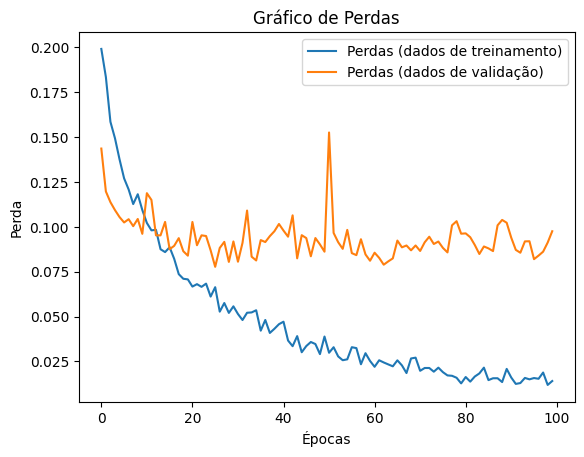

In [1]:
import matplotlib.pyplot as plt
import pickle

## PLoting graphs
# loss
with open("/content/drive/MyDrive/mba_tcc/drone_fine_tuning_VGG/loss.txt","rb") as file:
  loss = pickle.load(file)
# val_loss
with open("/content/drive/MyDrive/mba_tcc/drone_fine_tuning_VGG/val_loss.txt","rb") as file:
  val_loss = pickle.load(file)
# accuracy
with open("/content/drive/MyDrive/mba_tcc/drone_fine_tuning_VGG/accuracy.txt","rb") as file:
  accuracy = pickle.load(file)
# val_accuracy
with open("/content/drive/MyDrive/mba_tcc/drone_fine_tuning_VGG/val_accuracy.txt","rb") as file:
  val_accuracy = pickle.load(file)

plt.plot(loss)
plt.plot(val_loss)
plt.title('Gráfico de Perdas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Perdas (dados de treinamento)','Perdas (dados de validação)'])
plt.show()

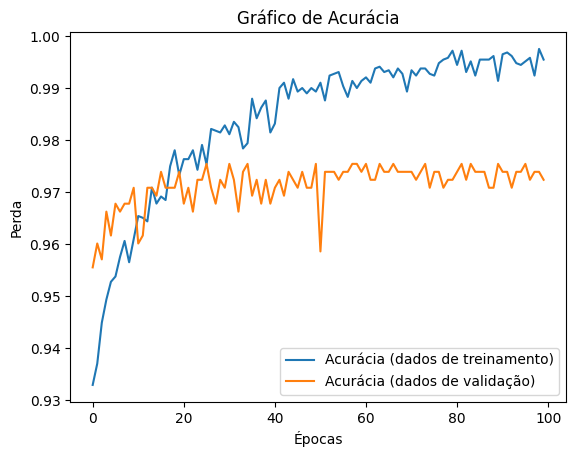

In [2]:
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('Gráfico de Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend(['Acurácia (dados de treinamento)','Acurácia (dados de validação)'])
plt.show()

# 4 - INSPECIONANDO MODELOS

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
### VGG16
# model_layers = VGG16(weights="imagenet",include_top=True)
model_layers = VGG16(weights="imagenet",include_top=False)

for (i,layer) in enumerate(model_layers.layers):
  print("[INFO] {}\t{}".format(i,layer.__class__.__name__))

[INFO] loading networks...
[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


# 5 - REFERÊNCIAS

https://stackoverflow.com/questions/60404341/validation-accuracy-val-acc-does-not-change-over-the-epochs  

https://stackoverflow.com/questions/66472383/transfer-learning-model-gives-0-accuracy-regardless-of-architecture  

https://stackoverflow.com/questions/61742556/valueerror-shapes-none-1-and-none-2-are-incompatible  

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator  

